# RAIL Estimation Tutorial For Delight

**Authors:** Sylvie Dagoret-Campagne

**Last run successfully:** October 31, 2024

This is a notebook demonstrating some of the `estimation` features of the LSST-DESC `RAIL`-iverse packages.  

The `rail.estimation` subpackage contains infrastructure to run multiple production-level photo-z codes.  There is a minimimal superclass that sets up some file paths and variable names. Each specific photo-z code resides in a subclass in `rail.estimation.algos` with algorithm-specific setup variables.  More extensive documentation is available on Read the Docs here:
https://rail-hub.readthedocs.io/en/latest/



### Define usefull environnement varible

In [1]:
%env PZDATALOC="/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/desc/rail_dspsXfors2_pz/src/rail/dsps_fors2_pz/data"

env: PZDATALOC="/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/desc/rail_dspsXfors2_pz/src/rail/dsps_fors2_pz/data"


### Check imports

- main branch of https://github.com/LSSTDESC/Delight
- forked, from https://github.com/sylvielsstfr/rail_delight, branch `Make-rail_delight-compatible-with-updated-cythonized-Delight`
- forked, from https://github.com/sylvielsstfr/rail, branch `demo-notebook-for-Delight` 

In [2]:
import delight

In [3]:
dir(delight)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'hmc',
 'io',
 'photoz_gp',
 'photoz_kernels',
 'photoz_kernels_cy',
 'posteriors',
 'priors',
 'sedmixture',
 'utils',
 'utils_cy']

In [4]:
from rail.estimation.algos import delight_hybrid

In [5]:
dir(delight_hybrid)

['CatEstimator',
 'CatInformer',
 'DelightEstimator',
 'DelightInformer',
 'Param',
 'RAILDIR',
 'TableHandle',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'errno',
 'logger',
 'logging',
 'np',
 'os',
 'qp',
 'sys']

### Other imports

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

In [7]:
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage

We'll start by setting up the `DataStore`.  RAIL uses [`ceci`](https://github.com/LSSTDESC/ceci) as a back-end for pipelines of RAIL stages run at the command line. The `DataStore` is a workaround to enable `ceci` to interact with data files in an interactive notebook environment.   Some files will appear in the `DataStore` with the prefix "inprogress_" as they are stored in memory for use in the notebook, but the data will also be written out to file with the prefix "output_".  See the Golden Spike end-to-end demo notebook for more details on the `DataStore`.

In [8]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## Importing all available estimators

There is some handy functionality in `rail.stages` to import all available stages that are installed in your environment.  `RailStage` knows about all of the sub-types of stages.  By looping through the values in  the `RailStage.pipeline_stages` dictionary, we can isolate those that are sub-classes of `rail.estimation.estimator.CatEstimator`, which operate on catalog-like inputs.  Let's run this `import_and_attach_all()` command, and then print out the subclasses that are now available for use (though in this demo we only take advantage of two specific estimators):

In [9]:
import rail.stages
rail.stages.import_and_attach_all()

for val in RailStage.pipeline_stages.values():
    if issubclass(val[0], rail.estimation.estimator.CatEstimator):
        print(val[0])

Imported rail.astro_tools
Imported rail.bpz
Imported rail.cmnn
Imported rail.core
Imported rail.delight
Imported rail.dsps
Imported rail.dsps_fors2_pz
Imported rail.flexzboost
Imported rail.fsps
Imported rail.gpz
Imported rail.hub
Imported rail.interfaces
Imported rail.pzflow
Imported rail.sklearn
Imported rail.som
Imported rail.stages
Attached 12 base classes and 83 fully formed stages to rail.stages
<class 'rail.estimation.estimator.CatEstimator'>
<class 'rail.estimation.algos.delight_hybrid.DelightEstimator'>
<class 'rail.estimation.algos.random_gauss.RandomGaussEstimator'>
<class 'rail.estimation.algos.train_z.TrainZEstimator'>
<class 'rail.estimation.algos.bpz_lite.BPZliteEstimator'>
<class 'rail.estimation.algos.cmnn.CMNNEstimator'>
<class 'rail.estimation.algos.flexzboost.FlexZBoostEstimator'>
<class 'rail.estimation.algos.gpz.GPzEstimator'>
<class 'rail.estimation.algos.pzflow_nf.PZFlowEstimator'>
<class 'rail.estimation.algos.k_nearneigh.KNearNeighEstimator'>
<class 'rail.esti

You should see a list of the available subclasses corresponding to specific photo-z algorithms, as printed out above.  These currently include:

- `bpz_lite` is a template-based code that outputs the posterior estimated given a specific template set and Bayesian prior. See [Benitez (2000)](http://stacks.iop.org/0004-637X/536/i=2/a=571) for more details.
- `cmnn` is an implementation of the "colour-matched nearest neighbour` estimator described in [Graham et al 2018](https://ui.adsabs.harvard.edu/abs/2018AJ....155....1G/abstract).  It returns a single Gaussian for each galaxy.
- `delight_hybrid` (currently `delightPZ`) is a hybrid gaussian process/template-based code. See the [Leistedt & Hogg (2017)](https://doi.org/10.3847%2F1538-3881%2Faa91d5) for more details.
- `flexzboost` is a fully functional photo-z algorithm, implementing the FlexZBoost conditional density estimate method from [Izbicki, Lee & Freeman (2017)](https://doi.org/10.1214/16-AOAS1013) that performed well in the LSST-DESC Photo-Z Data Challenge 1 paper ([Schmidt, Malz & Soo, et al. (2020)](https://academic.oup.com/mnras/article/499/2/1587/5905416)).  FlexZBoost and some specialized metrics for it are available in Python and R through [FlexCode](https://github.com/lee-group-cmu/FlexCode).
- `gpz` is a Gaussian Process-based estimator. See [Almosallam et al 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.462..726A/abstract) for details on the algorithm.  It currently returns a single Gaussian for each PDF.
- `k_nearneigh` is a simple implementation of a weighted k-nearest neighbor photo-z code. It stores each PDF as a weighted sum of Gaussians based on the distance from neighbors in color-space.<br>
- `pzflow_nf` uses the same normalizing flow code [pzflow](https://github.com/jfcrenshaw/pzflow), the same one that appears in `rail.creation`, to predict redshift PDFs.
- `random_gauss` is a very simple class that does not actually predict a meaningful photo-z but can be useful for quick null tests when developing a pipeline. Instead it produces a randomly drawn Gaussian for each galaxy.
- `sklearn_neurnet` is another toy model using `sklearn`'s neural network to predict a point estimate redshift from the training data, then assigns a sigma width based on the estimated redshift.
- `trainz` is our "pathological" estimator. It makes a PDF from a histogram of the training data and assigns that PDF to every galaxy without considering its photometry.


Each code should have two specific classes associated with it: one to `inform()` using a set of training data or explicit priors and one to `estimate()` the per-galaxy photo-z PDFs.  These should be imported from the `src/rail/estimation/algos/[name_of_code]` module using the above names. The naming pattern is `[NameOfCode]Estimator` for the estimating class, and `[NameOfCode]Informer` for the training/ingesting class, for example `FlexZBoostEstimator` and  `FlexZBoostInformer`.  

For each of these two classes, we follow the pattern to first run a `make_stage()` method for the class in order to set up the `ceci` infrastructure and then invoke the `inform()` or `estimate()` method for the class in question.  We show examples of this below.

In [10]:
from rail.estimation.algos import delight_hybrid

In [11]:
dir(delight_hybrid)

['CatEstimator',
 'CatInformer',
 'DelightEstimator',
 'DelightInformer',
 'Param',
 'RAILDIR',
 'TableHandle',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'errno',
 'logger',
 'logging',
 'np',
 'os',
 'qp',
 'sys']

In [12]:
dir(delight_hybrid.DelightInformer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_describe_configuration_text',
 '_finalize_tag',
 'add_data',
 'add_handle',
 'allow_reload',
 'already_finished',
 'build',
 'check_io',
 'comm',
 'config',
 'config_options',
 'connect_input',
 'dask_parallel',
 'data_ranges_by_rank',
 'data_store',
 'describe_configuration',
 'doc',
 'execute',
 'finalize',
 'find_inputs',
 'find_outputs',
 'generate_command',
 'generate_cwl',
 'get_aliased_tag',
 'get_aliases',
 'get_config_dict',
 'get_data',
 'get_handle',
 'get_input',
 'get_input_type',
 'get_module',
 'get_output',
 'get_output_type',
 'get_stage',
 'incomplete_pipeline_stages',
 'inform',
 'inp

## The code-specific parameters
Each photo-z algorithm has code-specific parameters necessary to initialize the code.  These values can be input on the command line, or passed in via a dictionary.<br>

Let's start with a very simple demonstration using `k_nearneigh`, a RAIL wrapper around `sklearn`'s nearest neighbor (NN) method.  It calculates a normalized weight for the K nearest neighbors based on their distance and makes a PDF as a sum of K Gaussians, each at the redshift of the training galaxy with amplitude based on the distance weight, and a Gaussian width set by the user.  This is a toy model estimator, but it actually performs very well for representative data sets. There are configuration parameters for the names of columns, random seeds, etc... in `KNearNeighEstimator` with best-guess sensible defaults based on preliminary experimentation in DESC. See the [KNearNeigh code](https://github.com/LSSTDESC/RAIL/blob/eac-dev/rail/estimation/algos/k_nearneigh.py) for more details, but here is a minimal set to run:

In [13]:
dlgt_dict = dict(zmin=0.0, zmax=3.0, nzbins=301, trainfrac=0.75,
                sigma_grid_min=0.01, sigma_grid_max=0.07, ngrid_sigma=10,hdf5_groupname='photometry')

Here, `trainfrac` sets the proportion of training data to use in training the algorithm, where the remaining fraction is used to validate both the width of the Gaussians used in constructing the PDF and the number of neighbors used in each PDF.  The CDE Loss is a metric computed on a grid of some width and number of neighbors, and the combination of width and number of neighbors with the lowest CDE loss is used.  `sigma_grid_min`, `sigma_grid_max`, and `ngrid_sigma` are used to specify the grid of sigma values to test, while `nneigh_min` and `nneigh_max` are the integer values between which we will check the loss.

`zmin`, `zmax`, and `nzbins` are used to create a grid on which the CDE Loss is computed when minimizing the loss to find the best values for sigma and number of neighbors to use.

We will begin by training the algorithm by instantiating its `Informer` stage.

If any essential parameters are missing from the parameter dictionary, they will be set to default values:

In [14]:
from rail.estimation.algos.delight_hybrid import DelightInformer, DelightEstimator
pz_train = DelightInformer.make_stage(name='inform_Delight', model='demo_delight.pkl', **dlgt_dict)

Now, let's load our training data, which is stored in hdf5 format.  We'll load it into the `DataStore` so that the `ceci` stages are able to access it.

In [15]:
from rail.utils.path_utils import find_rail_file
trainFile = find_rail_file('examples_data/testdata/test_dc2_training_9816.hdf5')
testFile = find_rail_file('examples_data/testdata/test_dc2_validation_9816.hdf5')
training_data = DS.read_file("training_data", TableHandle, trainFile)
test_data = DS.read_file("test_data", TableHandle, testFile)

We need to train the KDTree, which is done with the `inform()` method present in every `Informer` stage. The parameter `model` is the name that the trained model object that will be saved as, in a format specific to the estimation algorithm in question.  In this case the format is a pickle file called `demo_knn.pkl`. 

`KNearNeighInformer.inform` finds the best sigma and NNeigh and stores those along with the KDTree in the model.

In [16]:
%%time
pz_train.inform(training_data)

DC2LSST_u DC2LSST_g DC2LSST_r DC2LSST_i DC2LSST_z DC2LSST_y CPU times: user 1min 39s, sys: 1.08 s, total: 1min 40s
Wall time: 1min 43s


We can now set up the main photo-z `Estimator` stage and run our algorithm on the data to produce simple photo-z estimates.  Note that we are loading the trained model that we computed from the `Informer` stage:

In [19]:
pz = DelightEstimator.make_stage(name='inform_Delight', hdf5_groupname='photometry')
results = pz.estimate(test_data)

Process 0 running estimator on chunk 0 - 10000



 Starting estimation...



Process 0 estimating PZ PDF for rows 0 - 10,000
0 0.18297123908996582 0.010532855987548828 0.015620946884155273
100 0.15404081344604492 0.0065081119537353516 0.010738849639892578
200 0.16020512580871582 0.006026029586791992 0.00805974006652832
300 0.16328811645507812 0.00648188591003418 0.022724151611328125
400 0.14587187767028809 0.005042314529418945 0.00558781623840332
500 0.14836978912353516 0.004935264587402344 0.011224031448364258
600 0.149824857711792 0.007876873016357422 0.005347251892089844
700 0.1459188461303711 0.0046977996826171875 0.010361194610595703
800 0.142333984375 0.004642009735107422 0.01376795768737793
900 0.15506815910339355 0.0058917999267578125 0.00764012336730957
1000 0.14693284034729004 0.005136966705322266 0.013916254043579102
1100 0.14197015762329102 0.004743814468383789 0.01046299934387207
1200 0.15212798118591309 0.006071805953979492 0.007692098617553711
1300 0.1452488899230957 0.0

/Users/dagoret/anaconda3/envs/py312_rail/lib/python3.12/site-packages/qp/interp_pdf.py:88: RuntimeWarning: invalid value encountered in divide
  self._yvals = (self._yvals.T / self._ycumul[:, -1]).T
/Users/dagoret/anaconda3/envs/py312_rail/lib/python3.12/site-packages/qp/interp_pdf.py:89: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:, -1]).T


Inserting handle into data store.  output_inform_Delight: inprogress_output_inform_Delight.hdf5, inform_Delight
Process 0 running estimator on chunk 10000 - 20000



 Starting estimation...



Process 0 estimating PZ PDF for rows 10,000 - 20,000
0 0.20946788787841797 0.011907100677490234 0.013671875
100 0.1732616424560547 0.005181312561035156 0.007484912872314453
200 0.1725609302520752 0.007093906402587891 0.013584136962890625
300 0.16012001037597656 0.0051500797271728516 0.008650064468383789
400 0.1601099967956543 0.005476951599121094 0.004880189895629883
500 0.16064000129699707 0.005409955978393555 0.008172035217285156
600 0.2146449089050293 0.005322933197021484 0.010656118392944336
700 0.16657423973083496 0.006087779998779297 0.0052831172943115234
800 0.166306734085083 0.004930019378662109 0.004060983657836914
900 0.17404818534851074 0.008183956146240234 0.011759757995605469
1000 0.16400384902954102 0.005239963531494141 0.0044040679931640625
1100 0.16407132148742676 0.00785470008850

In [20]:
#pz = DelightEstimator.make_stage(name='inform_Delight', hdf5_groupname='photometry',
#                              model=pz_train.get_handle('model'))
#results = pz.estimate(test_data)

The output file is a `qp.Ensemble` containing the redshift PDFs.  This `Ensemble` also includes a photo-z point estimate derived from the PDFs, the mode by default (though there will soon be a keyword option to choose a different point estimation method or to skip the calculation of a point estimate).  The modes are stored in the "ancillary" data within the `Ensemble`.  By default it will be in an 1xM array, so you may need to include a `.flatten()` to flatten the array.  The zmode values in the ancillary data can be accessed via:

In [21]:
zmode = results().ancil['zmode'].flatten()

In [30]:
selected_flag =  zmode>=0

(array([ 9757.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10692.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

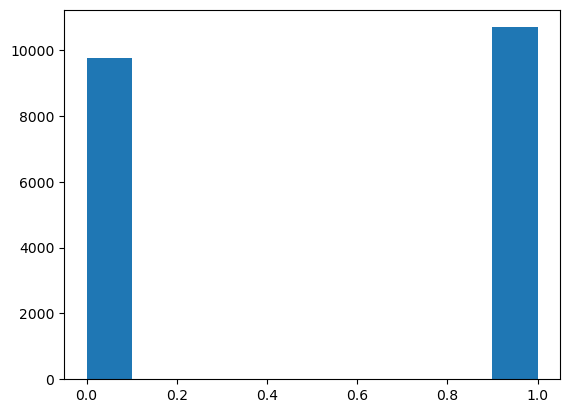

In [33]:
plt.hist(selected_flag.astype(int))

In [29]:
test_data()['photometry']['redshift']

array([0.02304609, 0.02187623, 0.0441931 , ..., 3.0210144 , 2.98104019,
       2.95916868])

Let's plot the redshift mode against the true redshifts to see how they look:

Text(0, 0.5, 'Delight photo-z')

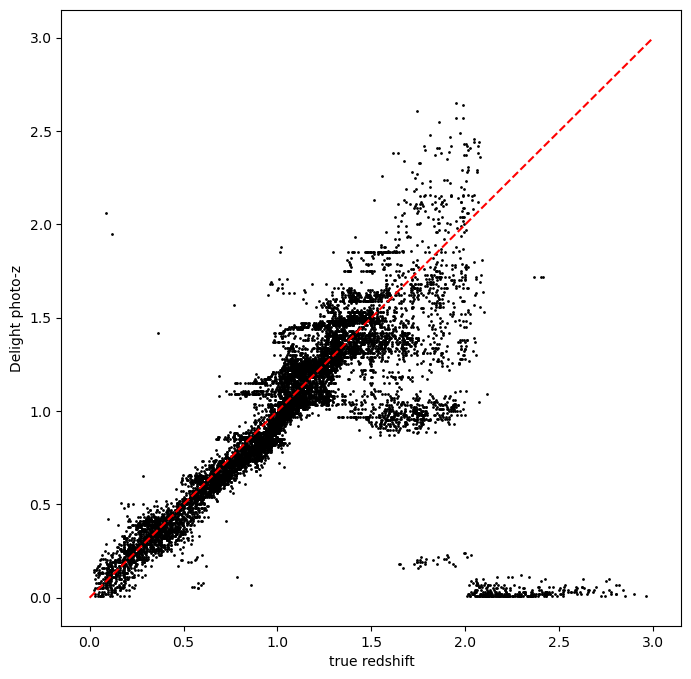

In [34]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'][selected_flag],zmode[selected_flag],s=1,c='k',label='simple NN mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("Delight photo-z")

Not bad, given our very simple estimator!  For the PDFs, `KNearNeigh` is storing each PDF as a Gaussian mixture model parameterization where each PDF is represented by a set of N Gaussians for each galaxy.  `qp.Ensemble` objects have all the methods of `scipy.stats.rv_continuous` objects so we can evaluate the PDF on a set of grid points with the built-in `.pdf` method.  Let's pick a single galaxy from our sample and evaluate and plot the PDF, the mode, and true redshift:

In [23]:
zgrid = np.linspace(0, 3., 301)

Text(0, 0.5, 'p(z)')

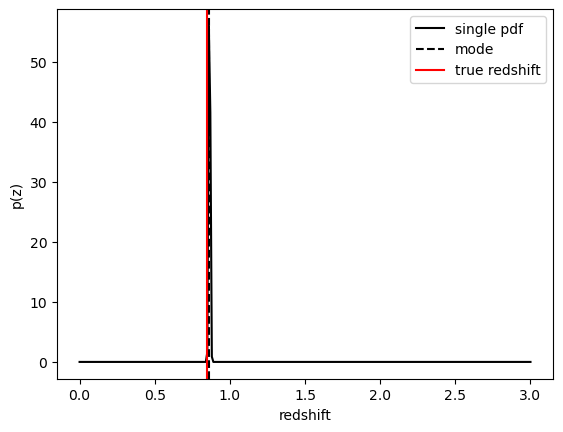

In [25]:
galid = 9528
single_gal = np.squeeze(results()[galid].pdf(zgrid))
single_zmode = zmode[galid]
truez = test_data()['photometry']['redshift'][galid]
plt.plot(zgrid,single_gal,color='k',label='single pdf')
plt.axvline(single_zmode,color='k', ls='--', label='mode')
plt.axvline(truez,color='r',label='true redshift')
plt.legend(loc='upper right')
plt.xlabel("redshift")
plt.ylabel("p(z)")

We see that KNearNeigh PDFs do consist of a number of discrete Gaussians, and many have quite a bit of substructure.  This is a naive estimator, and some of these features are likely spurious.